In [29]:
# here is how we activate an environment in our current directory
import Pkg; Pkg.activate(@__DIR__);

# instantate this environment (download packages if you haven't)
Pkg.instantiate();

import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating project at `~/Downloads/MSR Academics/zoe2_optimal_controller/julia`


In [30]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [177]:
function dynamics_bicycle(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ψ, θf, θr = x[1:5]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B
    ϵ = 1e-3

    v_f = r*(ω_fl+ω_fr)/2
    v_r = r*(ω_rl+ω_rr)/2
    v_b = (1/2)*(v_f/cos(θr)+v_r/cos(θf))*√(cos(θr)*cos(θf)*cos(θf+θr)+(1/4)*sin(θf+θr)^2)

    ẋ = v_b*cos(ψ)
    ẏ = v_b*sin(ψ)
    ψ̇ = (sin(θf+θr)/(2*L))*((v_f/cos(θr)+v_r/cos(θf)))
    θḟ = r*(ω_fr-ω_fl)/B
    θṙ = r*(ω_rl-ω_rr)/B

    xdot = [ẋ; ẏ; ψ̇; θḟ; θṙ]
    # @show v_b, θr, θf
    # @show xdot
    return xdot;
end

function new_dynamics_bicycle(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ψ, θf, θr = x[1:5]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B
    ϵ = 1e-6

    V_l = (r/2)*(ω_fl+ω_rl)
    V_r = (r/2)*(ω_fr+ω_rr)
    R = (L/2)*(V_l+V_r)/(V_r-V_l+ϵ)
    θf = atan(L/(2*R+ϵ))
    θr = atan(L/(2*R+ϵ))

    R_b = (L/(2*(tan(θf)+tan(θr))))*sqrt(((tan(θf)-tan(θr))^2+4))
    R_f = L/(cos(θf)*(tan(θf)+tan(θr)))
    R_r = L/(cos(θr)*(tan(θf)+tan(θr)))
    v_f = r*(ω_fl+ω_fr)/2
    v_r = r*(ω_rl+ω_rr)/2
    ψ̇f = v_f/R_f
    ψ̇r = v_r/R_r
    ψ̇ = (ψ̇f+ψ̇r)/2
    v_b = ψ̇*R_b

    # θ̇f_world = r*(ω_fr-ω_fl)/B
    # θ̇r_world = r*(ω_rl-ω_rr)/B

    # θ̇f_body = θ̇f_world - ψ̇
    # θ̇r_body = ψ̇ - θ̇r_world
    # @show θ̇f_world, ψ̇, θ̇f_body

    ẋ = v_b*cos(ψ)
    ẏ = v_b*sin(ψ)

    # xdot = [ẋ; ẏ; ψ̇; θ̇f_body; θ̇r_body]
    xdot = [ẋ; ẏ; ψ̇; 0; 0]
    # @show v_b, θr, θfx
    # @show xdot
    return xdot;
end

function dynamics(params::NamedTuple, x::Vector, u::Vector)
    # ODE, parametrized by params

    # physical parameters 
    r, L, B = params.r, params.L, params.B
    ωfl, ωfr, ωrl, ωrr = u
    xb, yb, ψb, θf, θr = x
    
    vf = r/2*(ωfl + ωfr)
    vr = r/2*(ωrl + ωrr)
    vb = 0.5*(vf/cos(θr) + vr/cos(θf)) * sqrt(cos(θr)*cos(θf)*cos(θf+θr) + 0.25*(sin(θf+θr))^2)

    xdot = [vb*cos(ψb);
            vb*sin(ψb);
            sin(θf+θr)/(2*L)*(vf/cos(θr) + vr/cos(θf));
            r/B*(ωfr - ωfl);
            r/B*(ωrl - ωrr)]

    return xdot
end

dynamics (generic function with 1 method)

In [178]:
function rk4(params::NamedTuple, model, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*model(params, x, u)
    k2 = dt*model(params, x + k1/2, u)
    k3 = dt*model(params, x + k2/2, u)
    k4 = dt*model(params, x + k3, u)

    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

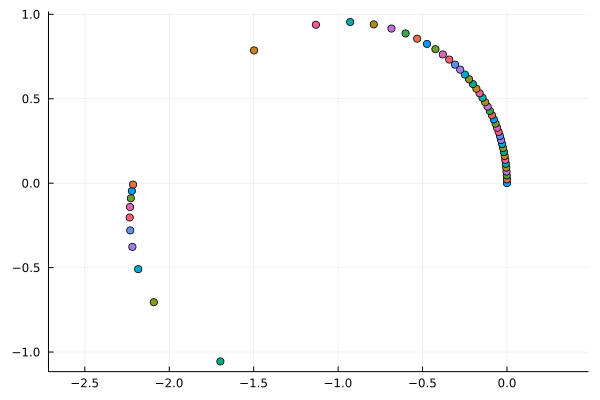

In [195]:
params = (r = 0.325, L = 1.91, B = 1.64)
u = [1.0, 3.0, 1.0, 3.0]

x0 = [0, 0, pi/2, pi/4, pi/4]
nx = 5
N = 50
dt = 0.05
t_vec = 0:dt:((N-1)*dt)

X = [zeros(nx) for i = 1:N]
X[1] = x0
for i = 1:(N-1)
    X[i+1] = rk4(params, dynamics, X[i], u, dt)
    if X[i+1][3] >= 2*pi
        X[i+1][3] %= 2*pi
    elseif X[i+1][3] < 0
        X[i+1][3] += 2*pi
    end

    if X[i+1][4] >= 2*pi
        X[i+1][4] %= 2*pi
    elseif X[i+1][4] < 0
        X[i+1][4] += 2*pi
    end

    if X[i+1][5] >= 2*pi
        X[i+1][5] %= 2*pi
    elseif X[i+1][5] < 0
        X[i+1][5] += 2*pi
    end
end

X = hcat(X...)
x = X[1,:]
y = X[2,:]

display(scatter(X[1,:]', X[2,:]', legend=false, aspect_ratio=:equal))